In [26]:
import pandas as pd
import numpy as np
import json
import csv
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings('ignore')

In [2]:
def get_exercise(file_path,id):
    with open(file_path, 'r') as json_file:
        js = json.load(json_file)
    exercise_df = json_normalize(js)
    exercise_df = exercise_df.drop(exercise_df.columns[26:], axis=1) #drop useless columns
    exercise_df['person_id'] = id
    return exercise_df

In [3]:
people = ['p01','p02','p03','p04','p05','p06','p07','p08','p09','p10','p11','p12','p13','p14','p15','p16']
ids = list(range(1, 17))

print("loading Dataset 2 exercise.cav ...")
exercise_df = pd.DataFrame()
for p,i in zip(people,ids):
    path = p + "\\fitbit\\exercise.json"
    exercise_df = pd.concat([exercise_df,get_exercise(path,i)])

exercise_df = exercise_df.drop(exercise_df.columns[27:], axis=1)
exercise_df = exercise_df.drop(['tcxLink','pace'], axis=1)
exercise_df['distance'] = exercise_df.apply(lambda row: row['distance'] * 1000 if row['distanceUnit'] == 'Kilometer' else row['distance'], axis=1)

exercise_df.to_csv('exercise.csv',index =False)
print(exercise_df.info())
print(exercise_df['activityName'].unique())

loading Dataset 2 exercise.cav ...
<class 'pandas.core.frame.DataFrame'>
Index: 2440 entries, 0 to 18
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   logId                           2440 non-null   int64  
 1   activityName                    2440 non-null   object 
 2   activityTypeId                  2440 non-null   int64  
 3   activityLevel                   2440 non-null   object 
 4   averageHeartRate                2427 non-null   float64
 5   calories                        2440 non-null   int64  
 6   duration                        2440 non-null   int64  
 7   activeDuration                  2440 non-null   int64  
 8   steps                           2271 non-null   float64
 9   logType                         2440 non-null   object 
 10  heartRateZones                  2425 non-null   object 
 11  lastModified                    2440 non-null   object 
 12  startT

1. Loading the dataset...
Initial shape of dataset: (2440, 25)

2. Initial Data Exploration

First few rows:
         logId activityName  activityTypeId  \
0  26451905128         Walk           90013   
1  26455950499         Walk           90013   
2  26467488515         Walk           90013   
3  26520401069         Walk           90013   
4  26538035127         Walk           90013   

                                       activityLevel  averageHeartRate  \
0  [{'minutes': 0, 'name': 'sedentary'}, {'minute...              94.0   
1  [{'minutes': 0, 'name': 'sedentary'}, {'minute...              94.0   
2  [{'minutes': 0, 'name': 'sedentary'}, {'minute...              98.0   
3  [{'minutes': 0, 'name': 'sedentary'}, {'minute...              97.0   
4  [{'minutes': 3, 'name': 'sedentary'}, {'minute...              93.0   

   calories  duration  activeDuration   steps        logType  ...  \
0       192   1331000         1331000  1878.0  auto_detected  ...   
1       302   2202000    

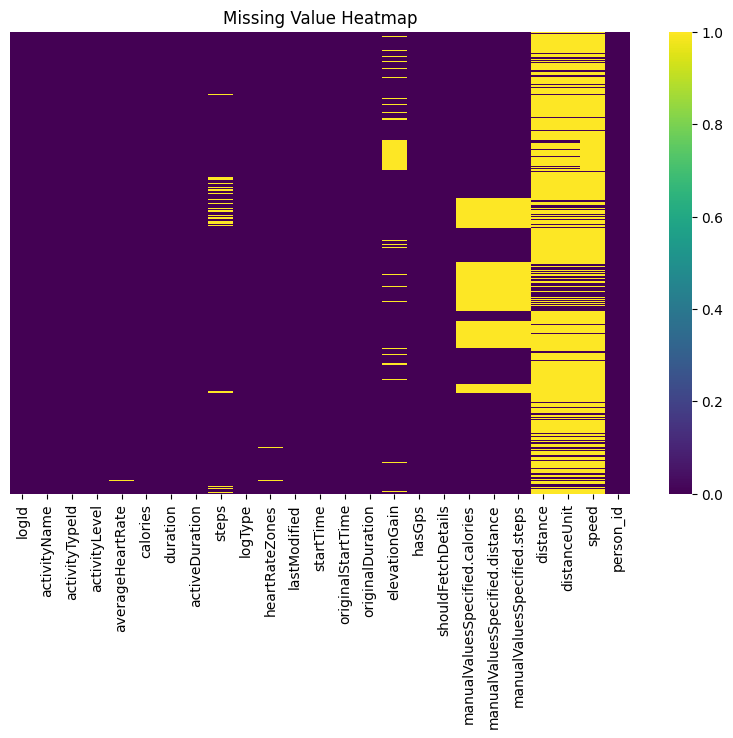


4. Data Cleaning

Removed 0 duplicate rows

5. Outlier Detection and Treatment

8. Generate Summary Statistics

Numerical Features Summary:
                          mean        median           std      skew
logId             2.815021e+10  2.813673e+10  9.741191e+08  0.158876
activityTypeId    6.827050e+04  9.001300e+04  3.552247e+04 -1.063838
averageHeartRate  1.129571e+02  1.070000e+02  1.970499e+01  0.758900
calories          3.290189e+02  2.320000e+02  2.428684e+02  1.136051
duration          2.277627e+06  1.741000e+06  1.464852e+06  1.127909
activeDuration    2.203964e+06  1.690000e+06  1.382451e+06  1.085545
steps             3.565569e+03  2.535000e+03  2.596069e+03  1.105041
originalDuration  2.273711e+06  1.741000e+06  1.460030e+06  1.127463
elevationGain     3.796927e+01  2.438400e+01  3.966304e+01  1.161375
distance          5.593354e+03  5.003707e+03  3.692673e+03  0.681630
speed             7.187883e+00  7.677550e+00  2.933294e+00 -0.530560
person_id         7.828279e+00 

In [4]:
name = 'exercise'
path = name+'.csv'
# 1. Data Loading
print("1. Loading the dataset...")
df = pd.read_csv(path)#'fitbit.csv'
print(f"Initial shape of dataset: {df.shape}")

# 2. Initial Data Exploration
print("\n2. Initial Data Exploration")
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())

print("\n3. Missing Value Analysis")
missing_stats = {
    col: {
        'missing_count': df[col].isnull().sum(),
        'missing_percentage': (df[col].isnull().sum() / len(df) * 100),
        'data_type': str(df[col].dtype)
    }
    for col in df.columns
}

missing_df = pd.DataFrame.from_dict(missing_stats, orient='index')
print("\nMissing value analysis:")
print(missing_df[missing_df['missing_count'] > 0])

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()



# 4. Data Cleaning
print("\n4. Data Cleaning")

# 4.1 Remove duplicates
initial_rows = len(df)
df = df.drop_duplicates()
print(f"\nRemoved {initial_rows - len(df)} duplicate rows")

# 4.2 Create a copy for cleaning approaches
df_imputed = df.copy()

# 4.3 Custom imputation using pandas and numpy
# Separate numerical and categorical columns using list comprehension
numerical_columns = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']


# Impute categorical columns with mode
# for col in categorical_columns:
#     df_imputed[col].fillna(df_imputed[col].mode()[0], inplace=True)

# 5. Outlier Detection and Treatment using numpy
print("\n5. Outlier Detection and Treatment")

# Dictionary comprehension for column statistics
column_stats = {
    col: {
        'q1': df_imputed[col].quantile(0.25),
        'q3': df_imputed[col].quantile(0.75),
        'iqr': df_imputed[col].quantile(0.75) - df_imputed[col].quantile(0.25)
    }
    for col in numerical_columns
}

# Treat outliers using IQR method
for col in numerical_columns:
    stats = column_stats[col]
    lower_bound = stats['q1'] - 1.5 * stats['iqr']
    upper_bound = stats['q3'] + 1.5 * stats['iqr']
    df_imputed[col] = df_imputed[col].clip(lower_bound, upper_bound)


# # 6. Feature Engineering
# # Add day of week
# print("\n7. Feature Engineering")
# df_imputed['day_of_week'] = pd.to_datetime(df_imputed['dateTime']).dt.day_name()


# 7. Create summary statistics using dictionary comprehension
print("\n8. Generate Summary Statistics")

summary_stats = {
    col: {
        'mean': df_imputed[col].mean(),
        'median': df_imputed[col].median(),
        'std': df_imputed[col].std(),
        'skew': df_imputed[col].skew()
    }
    for col in numerical_columns
}
print("\nNumerical Features Summary:")
print(pd.DataFrame.from_dict(summary_stats, orient='index'))

print("\nAnalysis completed!")
    

In [32]:
#treating missing values
#we will treat missing values based on the activity
df_imputed.dropna(subset=['averageHeartRate'],inplace=True)
#for distance 
print("Missing Values")
result = df_imputed.groupby('activityName')['distance'].apply(lambda x: x.isnull().sum())
print(result)
df_missing = df_imputed[df_imputed['distance'].isnull()]
print(df_missing['activityName'].unique())

#df_imputed.to_csv(name+'_data_imputed.csv', index=False)

Missing Values
activityName
Aerobic Workout            0
Bike                       0
Circuit Training           0
Cross Country Skiing       2
Dancing                    0
Elliptical                 9
Hike                      15
Interval Workout           0
Outdoor Bike             148
Run                       50
Skiing                     0
Spinning                   0
Sport                     91
Tennis                     0
Treadmill                  0
Walk                    1368
Weights                    0
Workout                    0
Yoga                       0
Name: distance, dtype: int64
['Walk' 'Sport' 'Run' 'Outdoor Bike' 'Cross Country Skiing' 'Elliptical'
 'Hike']


There are 1368 missing values for distance while walking, which is almost half, which is why we cannot consider for our ananlysis 

In [6]:
def correlations(path_imputed):
    df = pd.read_csv(path_imputed)#'fitbit_data_imputed.csv'
    numerical_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    # 1. Data Quality Visualization
    plt.figure(figsize=(15, 10))
    
    # Distribution plots for numerical features
    
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(4, 4, i)
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()
    
    # Box plots for outlier visualization
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(4, 4, i)
        sns.boxplot(data=df, y=col)
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()


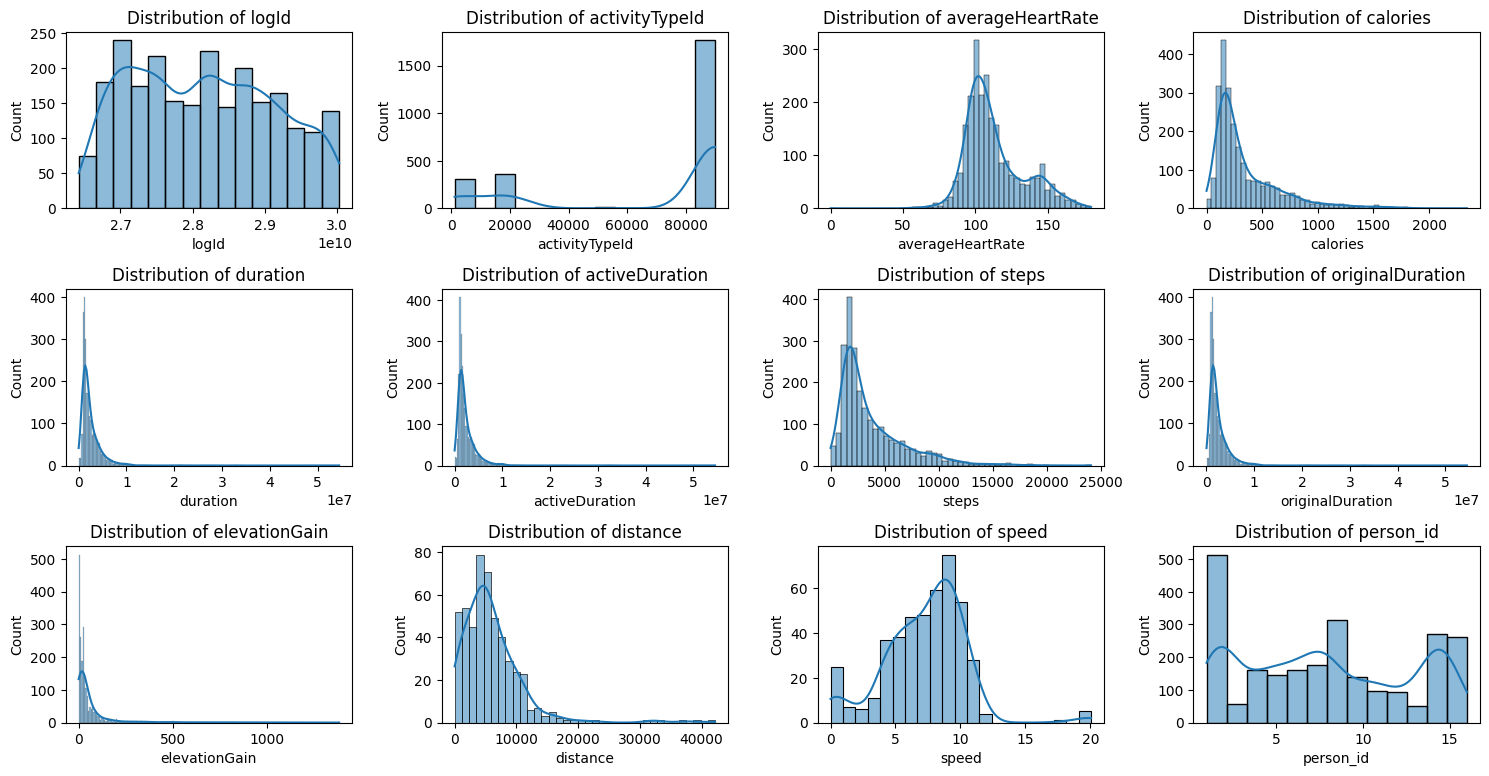

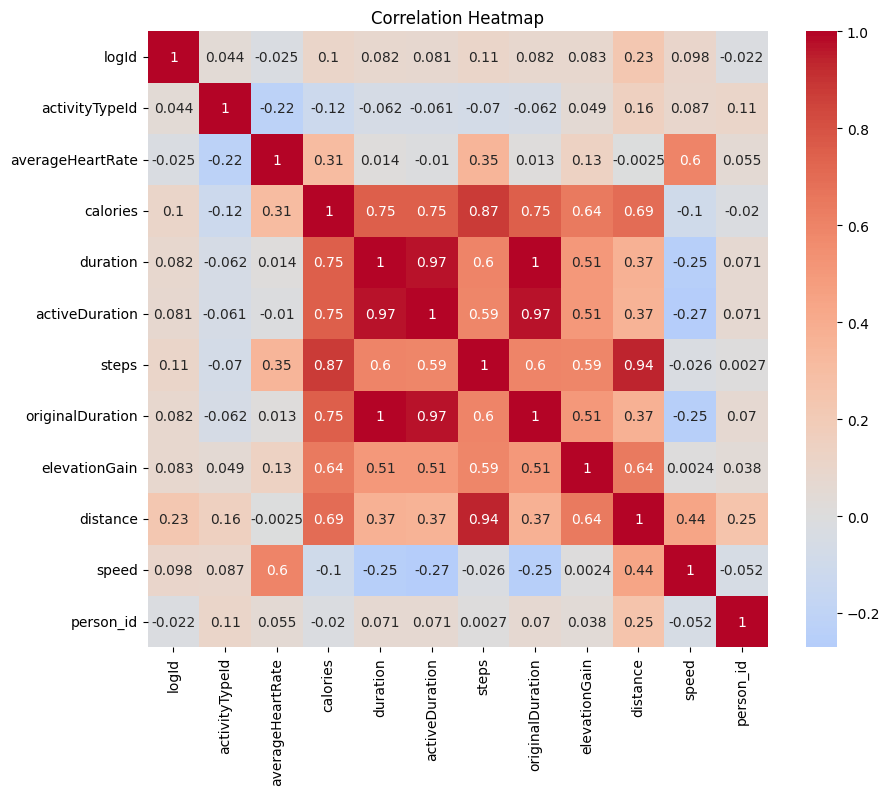

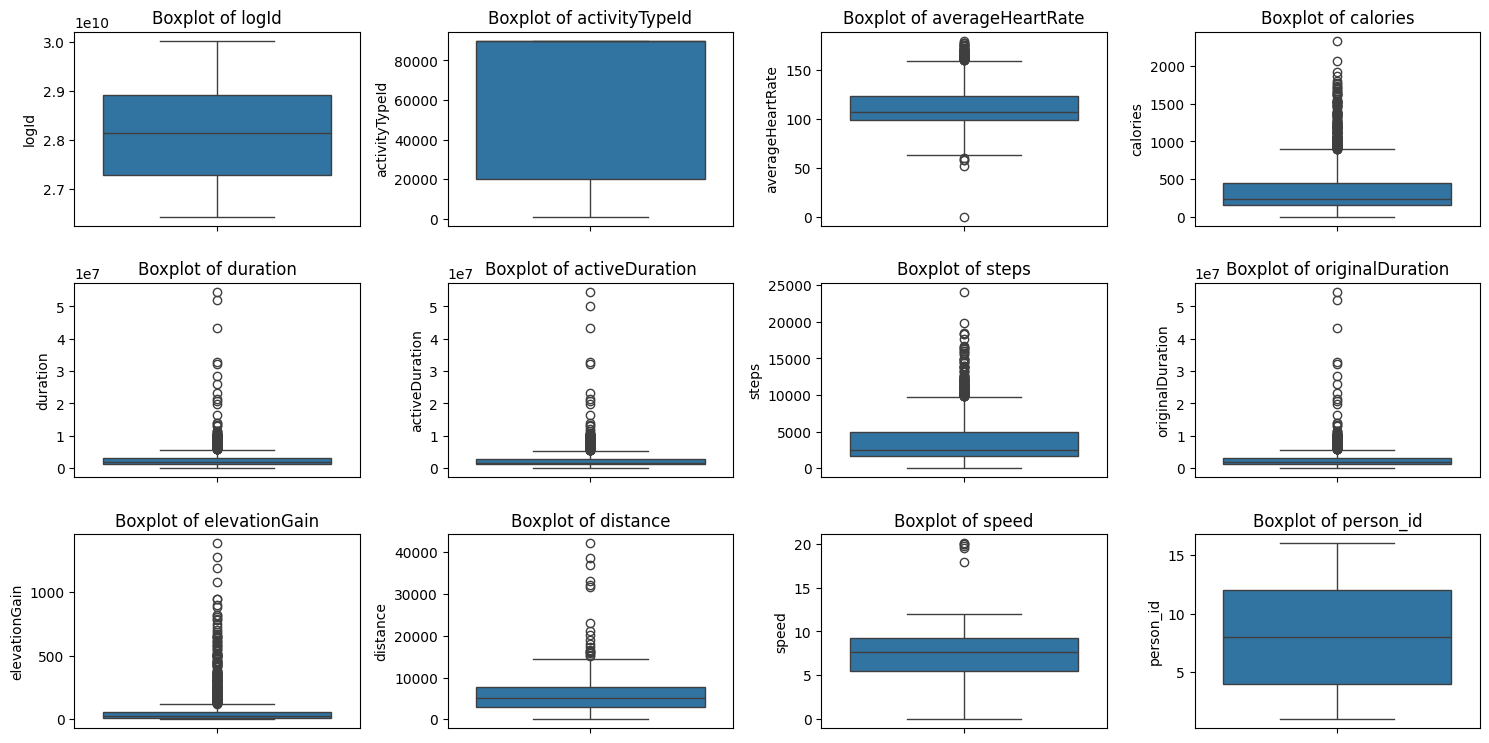

In [7]:
correlations('exercise.csv')

In [19]:

numerical_columns = [col for col in exercise_df.columns if exercise_df[col].dtype in ['float64', 'int64']]
df = exercise_df[numerical_columns] 
X = df.drop(['logId','person_id','speed','distance'],axis=1)
X = X.dropna()

freq = X['activityTypeId'].value_counts()
X = X[X['activityTypeId'].map(freq) >= 5]

y = X.activityTypeId
X = X.drop(['activityTypeId'],axis=1)

print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1965 entries, 0 to 17
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   averageHeartRate  1965 non-null   float64
 1   calories          1965 non-null   int64  
 2   duration          1965 non-null   int64  
 3   activeDuration    1965 non-null   int64  
 4   steps             1965 non-null   float64
 5   originalDuration  1965 non-null   int64  
 6   elevationGain     1965 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 122.8 KB
None


In [31]:
pca = PCA()
X_new = pca.fit_transform(X)

pca=PCA(n_components=2) #components were calculated using hit and trial by checking model accuracy
X_new=pca.fit_transform(X)

X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=20, stratify=y)
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=20, stratify=y)

knn_pca = KNeighborsClassifier(7)
knn_pca.fit(X_train_new,y_train)
print("Train score after PCA",knn_pca.score(X_train_new,y_train),"%")
print("Test score after PCA",knn_pca.score(X_test_new,y_test),"%")

Train score after PCA 0.7774545454545455 %
Test score after PCA 0.7220338983050848 %
